In [1]:
import os


import torch as th
import torch.nn.functional as F
import torch.nn as nn

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import torchvision.transforms as T

import albumentations as A

from tqdm import tqdm
import numpy as np
import pandas as pd
import cv2
import open_clip
from PIL import Image
import faiss

import matplotlib.pyplot as plt

import utilities

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [4]:
import PIL.Image
from PIL.ExifTags import TAGS
from pprint import pprint

image = PIL.Image.open('../development_test_data/gallery/abiding-debonair-viper-of-downpour.jpg')

# Get the exif data and map to the correct tags
exifdata = image.getexif()
for tag_id in exifdata:
    # get the tag name, instead of human unreadable tag id
    tag = TAGS.get(tag_id, tag_id)
    data = exifdata.get(tag_id)
    # decode bytes 
    if isinstance(data, bytes):
        data = data.decode()
    print(f"{tag:25}: {data}")
    
info_dict = {
    "Filename": image.filename,
    "Image Size": image.size,
    "Image Height": image.height,
    "Image Width": image.width,
    "Image Format": image.format,
    "Image Mode": image.mode,
    "Image is Animated": getattr(image, "is_animated", False),
    "Frames in Image": getattr(image, "n_frames", 1)
}

for label,value in info_dict.items():
    print(f"{label:25}: {value}")

Filename                 : ../development_test_data/gallery/abiding-debonair-viper-of-downpour.jpg
Image Size               : (800, 1000)
Image Height             : 1000
Image Width              : 800
Image Format             : JPEG
Image Mode               : RGB
Image is Animated        : False
Frames in Image          : 1


In [8]:
import json

b = '{"asin": "9707716371", "title": "PowerBear kompatibel f\u00fcr Samsung Galaxy S5 Erweiterte Batterie [7800mAh] & R\u00fcckenschutz & Schutzgeh\u00e4use (Bis zu 2,75x Zus\u00e4tzliche Batterieleistung) \u2013 Schwarz [24 Monate Garantie]", "averageRating": "4", "ratingCount": "222 globale Bewertungen", "amazon_badge": "", "ratingDist": {"5": "56%", "4": "16%", "3": "12%", "2": "6%", "1": "11%"}, "ratingByFeature": {}, "price": "", "imgUrl": "{\"https://images-na.ssl-images-amazon.com/images/I/81-0P2f1IbL._AC_SY450_.jpg\":[450,435],\"https://images-na.ssl-images-amazon.com/images/I/81-0P2f1IbL._AC_SX679_.jpg\":[703,679],\"https://images-na.ssl-images-amazon.com/images/I/81-0P2f1IbL._AC_SX466_.jpg\":[482,466],\"https://images-na.ssl-images-amazon.com/images/I/81-0P2f1IbL._AC_SX425_.jpg\":[440,425],\"https://images-na.ssl-images-amazon.com/images/I/81-0P2f1IbL._AC_SX569_.jpg\":[589,569],\"https://images-na.ssl-images-amazon.com/images/I/81-0P2f1IbL._AC_SX522_.jpg\":[540,522],\"https://images-na.ssl-images-amazon.com/images/I/81-0P2f1IbL._AC_SY355_.jpg\":[355,343]}", "related": {"sponsored": ["B08F72WCJ6", "B07X25HW97", "B06XHHWYYK", "B08F71WDZF", "B07PY671BJ", "B07WLJTS57", "B07WHLMVFN", "B0816MNBTT", "B08FX1DDTD", "B076GPK2FF"], "alsoBought": [], "alsoViewed": ["B07PY671BJ", "B06XHHWYYK"], "boughtTogether": [], "compared": []}, "productDetails": {}, "sellerPage": "/PowerBear/b/ref=bl_dp_s_web_17707234031?ie=UTF8&node=17707234031&field-lbr_brands_browse-bin=PowerBear", "categories": ["Elektronik & Foto", "Handys & Zubeh\u00f6r", "Zubeh\u00f6r", "H\u00fcllen & Cases", "Akkuh\u00fcllen"], "description": "", "overviewFeatures": {}, "features": ["Geben Sie Ihr Modell ein,\num sicherzustellen, dass dieser Artikel passt.", "GEHEN SIE \u00dcBER IHRE LEISTUNG HINAUS: Erh\u00f6hen sie ihre batterieleistung mit der erweiterten PowerBear Galaxy S5 batterie. Eine ieistungsf\u00e4hige batterie mit bis zu 275% Kapazit\u00e4t der standardbatterie f\u00fcr ihr smartphone.", "MAXIMIEREN SIE IHRE LEISTUNG: Mit der erweiterten Samsung Galaxy S5 batterie haben sie die m\u00f6glichkeit, ihre batteriekapazit\u00e4t drastisch zu erh\u00f6hen. Verglichen mit der vorhandenen standardbatteriekapazit\u00e4t ihres ger\u00e4ts k\u00f6nnen sie ihre batterieleistung mehr als verdoppeln.", "EINFACH ZU NUTZEN: Diese erweiterte S5 batterie ist extrem einfach zu installieren und zu nutzen. Nachdem sie ihr ger\u00e4t ausgeschaltet haben, entfernen sie einfach den r\u00fcckendeckel ihres smartphones zusammen mit der aktuellen Batterie.", "KATEGORIE A+ BATTERIEZELLEN: Die erweiterte batterie f\u00fcr das Samsung Galaxy S5 nutzt kategorie A+ batteriezellen mit zertifizierungen von CE und ROHS. Jede batterie wird mit einem speziellen chip geliefert, um ihr smartphone vor \u00fcberhitzung, kurzschl\u00fcssen, \u00fcberladen oder entladen zu sch\u00fctzen.", "24 MONATE GARANTIE: PowerBear steht hinter seinen Produkten. Sollten Sie nicht 100% zufrieden mit Ihrer neuen Galaxy S5 Batterie sein, lassen Sie uns das bitte umgehen wissen! Kontaktieren Sie uns \u00fcber Amazon und wir k\u00f6nnen Ihnen bei s\u00e4mtlichen Problem helfen, die Sie haben m\u00f6gen. Kundenzufriedenheit ist unsere h\u00f6chste Priorit\u00e4t und das ist die PowerBear Garantie!"], "reviewFilters": []}'
a = json.loads(b)


JSONDecodeError: Expecting ',' delimiter: line 1 column 423 (char 422)

In [2]:
# get product 10k

def read_img(img_path, is_gray=False):
    mode = cv2.IMREAD_COLOR if not is_gray else cv2.IMREAD_GRAYSCALE
    img = cv2.imread(img_path, mode)
    if not is_gray:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

class ProductDataset(Dataset):
    def __init__(self, 
                 img_dir, 
                 annotations_file, 
                 transform=None, 
                 final_transform=None, 
                 headers=None,
                 test_mode=False):
        self.data = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.final_transform = final_transform
        self.headers = {"img_path": "img_path", "product_id": "product_id"}
        if headers:
            self.headers = headers
        self.test_mode = test_mode
            
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.data[self.headers["img_path"]][idx])
        
        img = read_img(img_path)
        if self.test_mode:
            x, y, w, h = self.data["bbox_x"][idx], self.data["bbox_y"][idx], \
                         self.data["bbox_w"][idx], self.data["bbox_h"][idx]
            img = img[y:y+h, x:x+w]
            
        
        if self.transform is not None:
            img = transform(image=img)["image"]
        
        if self.final_transform is not None:
            if isinstance(img, np.ndarray):
                img =  Image.fromarray(img)
            img = self.final_transform(img)
            
        meta_data = {
            "product_id": self.data[self.headers["product_id"]][idx],
            "img_path":  self.data[self.headers["img_path"]][idx]
        }
        return img, meta_data
    
def get_final_transform():  
    final_transform = T.Compose([
            T.Resize(
                size=(224, 224), 
                interpolation=T.InterpolationMode.BICUBIC,
                antialias=True),
            T.ToTensor(), 
            T.Normalize(
                mean=(0.48145466, 0.4578275, 0.40821073), 
                std=(0.26862954, 0.26130258, 0.27577711)
            )
        ])
    return final_transform


# TAKEN FROM: https://github.com/IvanAer/G-Universal-CLIP 
class Multisample_Dropout(nn.Module):
    def __init__(self):
        super(Multisample_Dropout, self).__init__()
        self.dropout = nn.Dropout(.1)
        self.dropouts = nn.ModuleList([nn.Dropout((i+1)*.1) for i in range(5)])
        
    def forward(self, x, module):
        x = self.dropout(x)
        return th.mean(th.stack([module(dropout(x)) for dropout in self.dropouts],dim=0),dim=0) 

class Head(nn.Module):
    def __init__(self, hidden_size):
        super(Head, self).__init__()

        self.emb = nn.Linear(hidden_size, 512, bias=False)
        self.dropout = Multisample_Dropout()

    def forward(self, x):
        embeddings = self.dropout(x, self.emb)
        return F.normalize(embeddings)
    
class Model(nn.Module):
    def __init__(self, vit_backbone):
        super(Model, self).__init__()
        self.encoder = vit_backbone.visual
        self.head = Head(1024)

    def forward(self, x):
        x = self.encoder(x)
        return self.head(x)

In [3]:
vit_backbone, _, _ = open_clip.create_model_and_transforms(
    'ViT-H-14', pretrained=None
)

model = vit_backbone.visual
model.load_state_dict(th.load( f'/home/cemmi/Documents/aicrowd/G-Universal-CLIP/my_experiments/soup_slim.pt'))
model.half()
model.eval()
model.cuda()
print()

In [4]:
from sklearn.preprocessing import normalize

@th.no_grad()
def extract_embeddings(model, dataloader, epoch=10, use_cuda=True):
    features = []
    meta_data = []
    
    for _ in range(epoch):
        for imgs, meta in tqdm(dataloader):
            if use_cuda:
                imgs = imgs.cuda()
            features.append(th.squeeze(model(imgs.half())).detach().cpu().numpy().astype(np.float32))
            meta_data.append(meta)
    
    # to lazy to fix it so workaround
    img_path = []
    for m in meta_data:
        img_path.extend(m['img_path'])
        
    product_id = th.concat(tuple(m['product_id'] for m in meta_data)).detach().cpu().numpy()
    

    return np.concatenate(features, axis=0), img_path, product_id

In [5]:
img_dir = "../development_test_data"

In [6]:
final_transform = get_final_transform()

dataset_test = ProductDataset(img_dir, os.path.join(img_dir, "queries.csv"), None, final_transform, test_mode=True)
dataloader_test = DataLoader(dataset_test, batch_size=512, num_workers=4)

features_test, img_path_test, product_id_test = extract_embeddings(model, dataloader_test, 1)

dataset_train = ProductDataset(img_dir, os.path.join(img_dir, "gallery.csv"), None, final_transform)
dataloader_train = DataLoader(dataset_train, batch_size=512, num_workers=4)

features_train, img_path_train, product_id_train = extract_embeddings(model, dataloader_train, 1)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:12<00:00,  4.05s/it]


In [7]:
product_10k_features = np.concatenate([features_train, features_test], axis=0)
product_10k_features.shape

(3002, 1024)

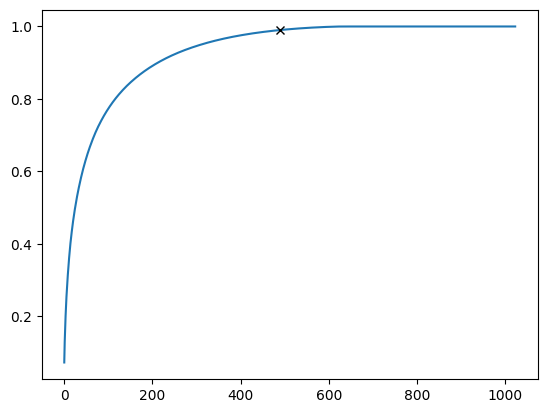

In [8]:
# do PCA
import sklearn.decomposition as D
import pickle

# transform data
pca = D.PCA().fit(product_10k_features)
var_sum = np.cumsum(pca.explained_variance_ratio_)
idx = np.where(var_sum > 0.99)[0][0]

pca_path = 'my_experiments/pca_soup.pkl'
pca_ = D.PCA(idx).fit(product_10k_features)
with open(pca_path, 'wb') as f:
    pickle.dump(pca_, f)

plt.plot(range(len(pca.explained_variance_ratio_)), np.cumsum(pca.explained_variance_ratio_), '-')
plt.plot(idx, var_sum[idx], 'xk')

In [12]:
features_test = pca_.transform(features_test)
features_train = pca_.transform(features_train)

In [8]:
dist, ind = utilities.get_similiarity_l2(features_train, features_test, 10000)

Processing indices...
Finished processing indices, took 0.28960490226745605s


In [9]:
def calculate_map_scores(product_id_test, product_id_train, ind):
    map_score_per_image = []

    for i, product_id in enumerate(tqdm(product_id_test)): 
        loc_ = np.where(product_id_train[ind[i]] == product_id_test[i])[0] + 1
        map_score_per_image.append(np.sum(np.arange(1, len(loc_[:3]) + 1) / loc_[:3]) / 3)

    map_score_per_image = np.array(map_score_per_image)
    print(f"Mean AP@3 is {np.mean(map_score_per_image)}")
    worst_to_best = np.argsort(map_score_per_image)
    return worst_to_best, map_score_per_image


In [10]:
worst_to_best, map_score_per_image = calculate_map_scores(product_id_test, product_id_train, ind)

100%|███████████████████████████████████████████████████████████████████████████████████| 1935/1935 [00:00<00:00, 57190.62it/s]

Mean AP@3 is 0.34448181569394537


In [11]:
def plot_img(img_dir, 
             img_path_q, 
             img_path_g, 
             product_id_q, 
             product_id_g, 
             distances,
             map_score
            ):
    imgs = [read_img(os.path.join(img_dir, img_path_q))]
    imgs.extend([read_img(os.path.join(img_dir, img_path)) for img_path in img_path_g])
    
    fig = plt.figure(figsize=(26, 4))
    for i in range(len(imgs)):
        img = imgs[i]
        fig.add_subplot(1, len(imgs) + 1, i+1)
        if i == 0:
            title = f'Product ({product_id_q})\nP@3({map_score:.2f})'
        else:
            title = f'''Product ({product_id_g[i-1]})\nDist({distances[i-1]:.2f})'''
        plt.title(title, fontsize=10)
        plt.imshow(img)
        plt.axis('off')
    plt.show()

206 predictions [3614 3569 3705 3705 3611 3670 3601 3484 3484 3640 3640 3577 3579 3488
 3610] truth 3546


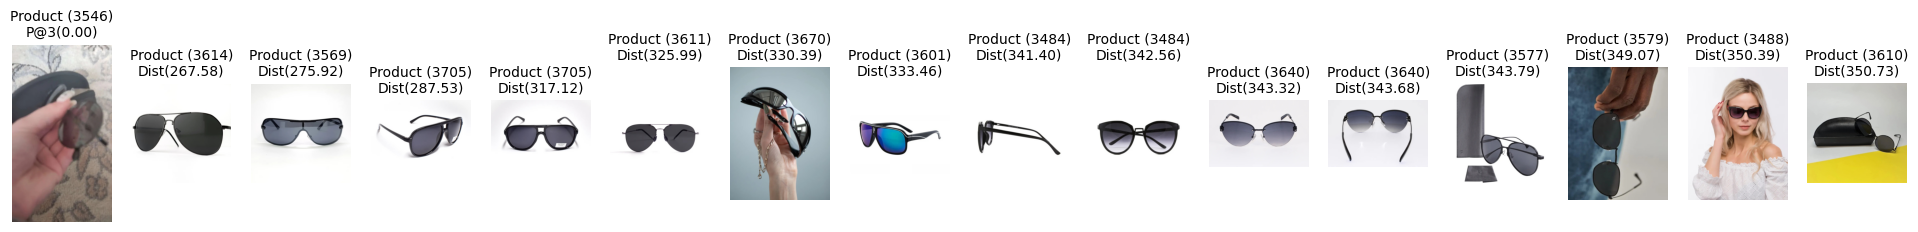

1135 predictions [5320 5039 4964 5337 5006 5006 5230 5230 5258 5230 5294 5261 5074 5118
 5232] truth 5314


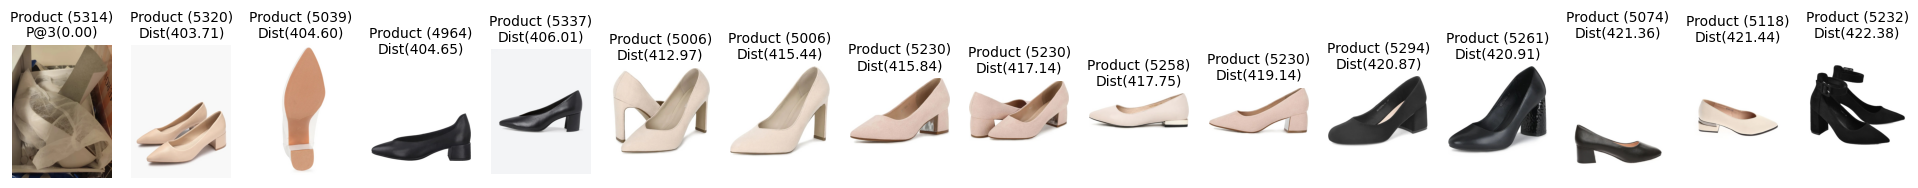

1708 predictions [3692 3552 3662 3612 3684 3468 3655 3668 3525 3554 3483 3612 3552 3488
 3666] truth 3568


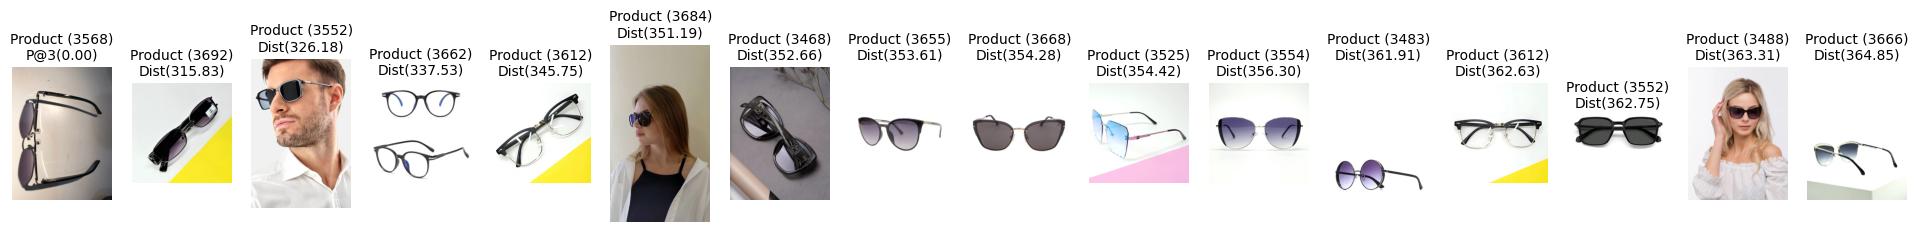

645 predictions [   5 5310 5336 5310 5106 5140 3512 3604   10 3488 5316 4951 3701 5077
 5316] truth 3634


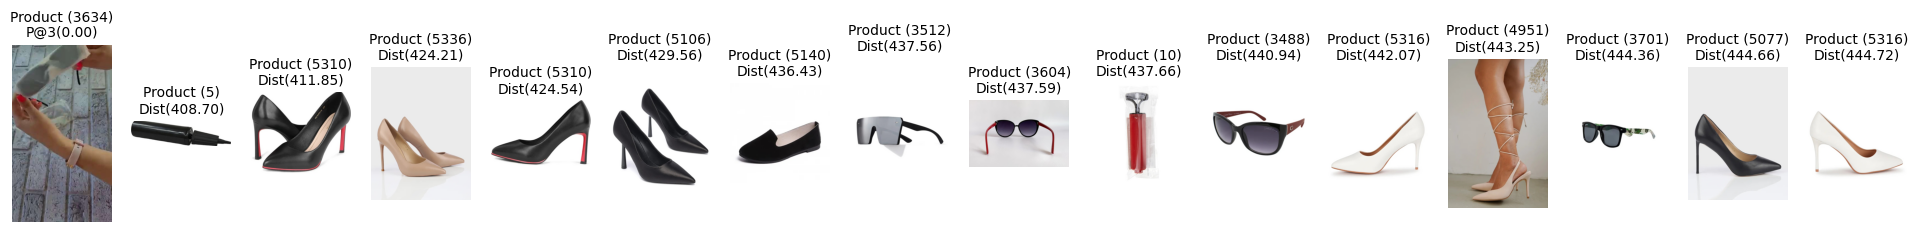

270 predictions [5226 5226 5006 5308 3520 5118 5246 3627 5006 5126 5031 5106 4964 5320
 5137] truth 5042


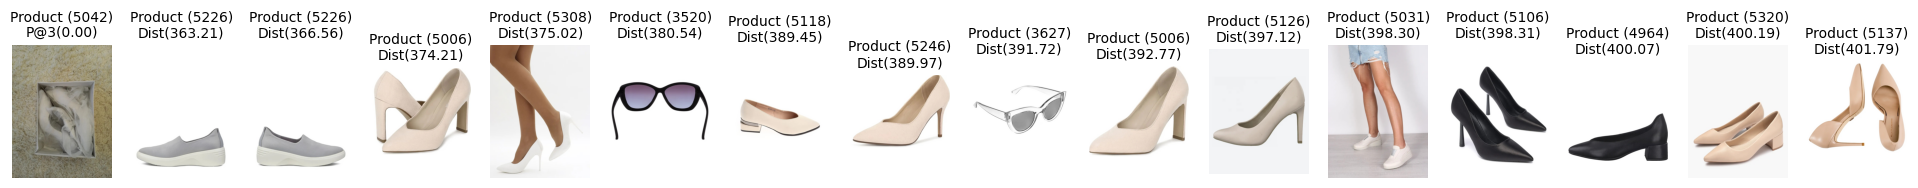

1330 predictions [5141 5087 5087 4978 5316 5109 5010 5257 5197 5320 5316 5336 5197 5351
 5141] truth 5198


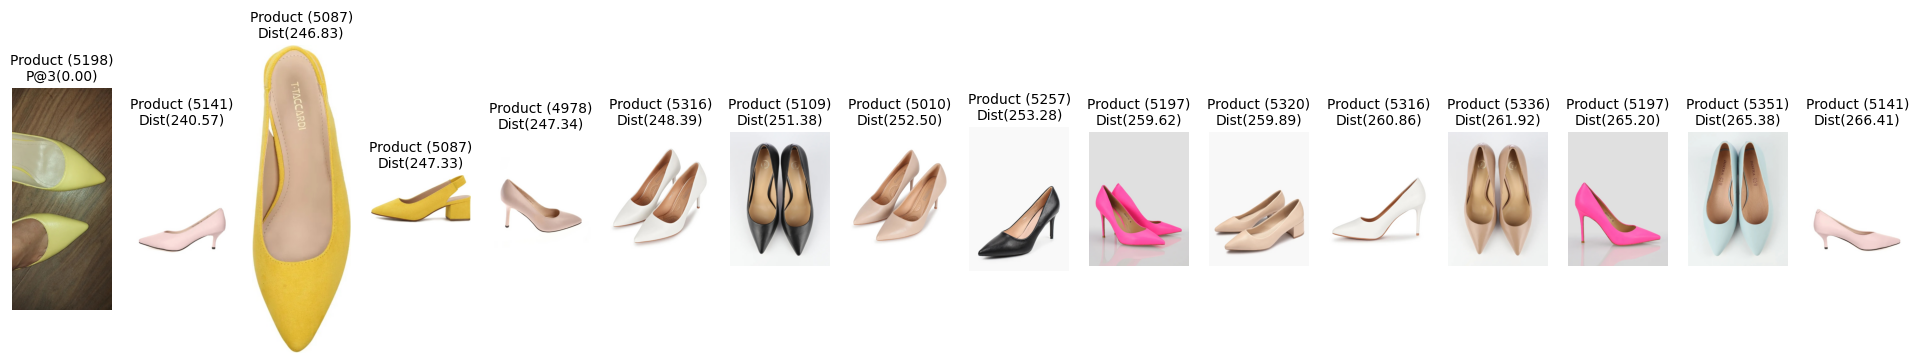

1386 predictions [5040 5140 5023 5201 3619 5189 5140 4993 5154 5294 3696 3512 5207 3676
 4955] truth 4981


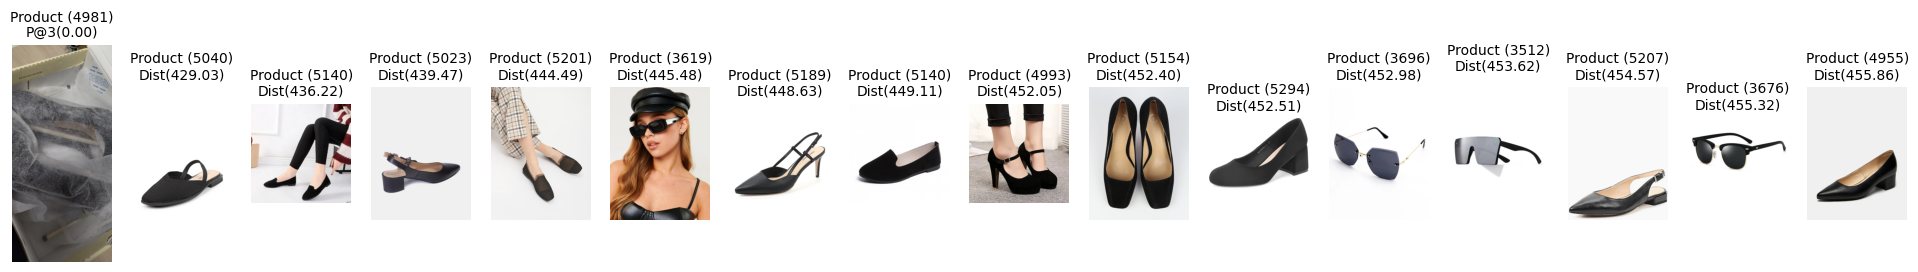

1829 predictions [5291 5279 5073 5349 5073 5297 5345 5296 5296 5078 5297 5196 5111 5070
 5073] truth 5347


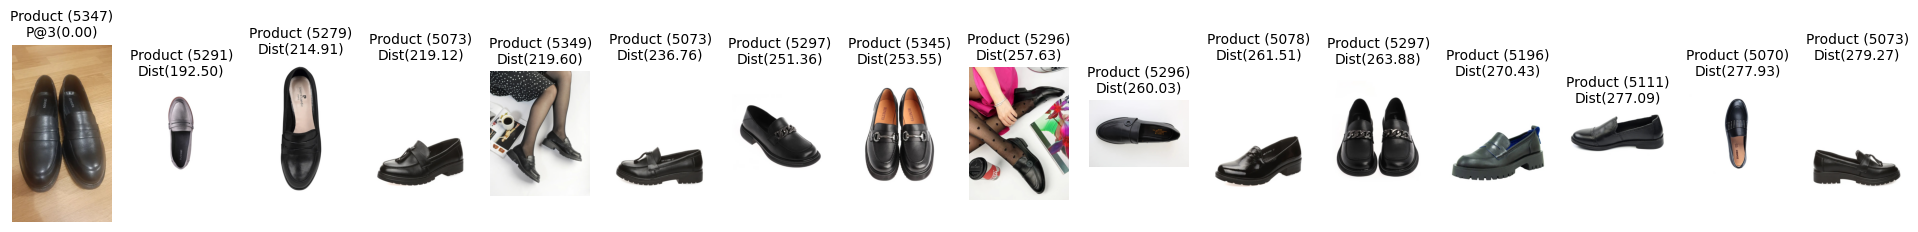

1317 predictions [3512 5166 3557 3555 3619 3462 3527 3520 3473 5106 5197 5020 3557 5257
 3575] truth 4951


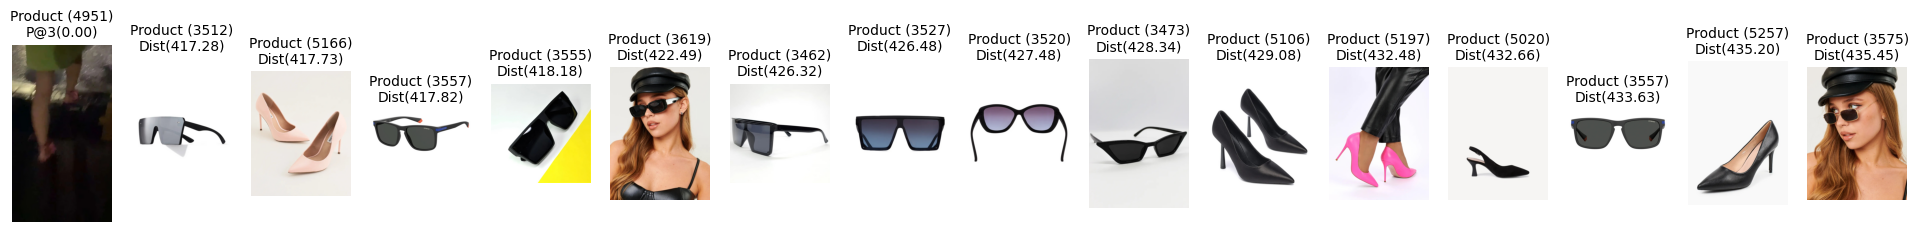

1300 predictions [5197 4978 5197 5197 5106 5248 5257 5109 5336 5316 5141 5316 5077 5087
 5166] truth 5198


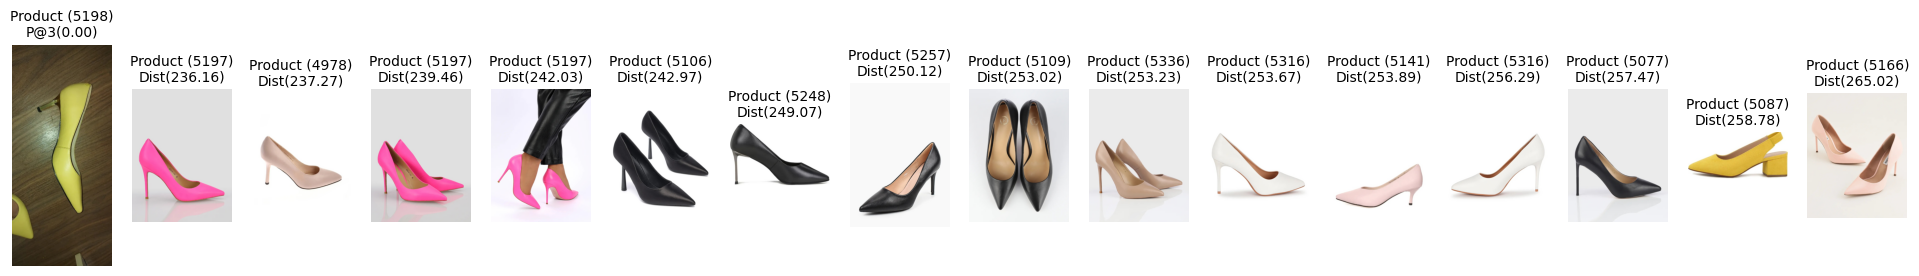

In [19]:
for i in worst_to_best[0:10]:
    idx_ = ind[i][:15]
    
    print(i, 'predictions', product_id_train[idx_], 'truth', product_id_test[i])
    img_path_q = img_path_test[i]
    img_path_g = [img_path_train[j] for j in idx_]
    plot_img(img_dir, 
             img_path_q, 
             img_path_g, 
             product_id_test[i], 
             product_id_train[idx_], 
             dist[i],
             map_score_per_image[i])

141 predictions [5024 5024 5024 5024 5223 5302 5142 5302 5019 5302 5047 5019 5223 5038
 5038] truth 5024


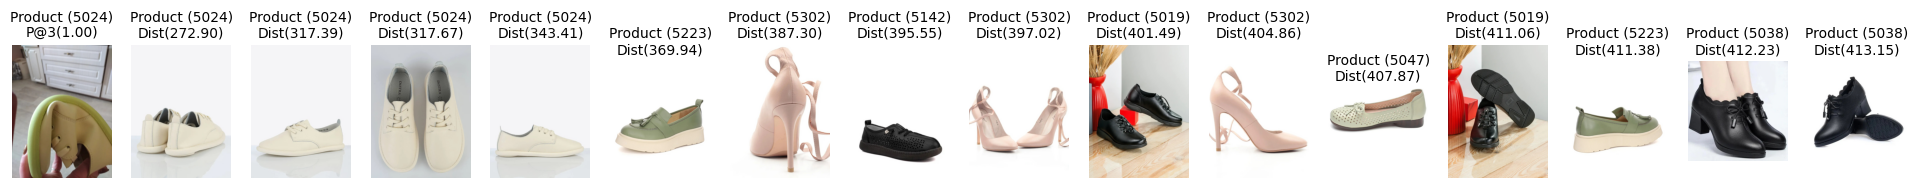

579 predictions [5210 5210 5210 5047 5329 5201 5009 5209 5009 5155 5184 5180 5201 5329
 5329] truth 5210


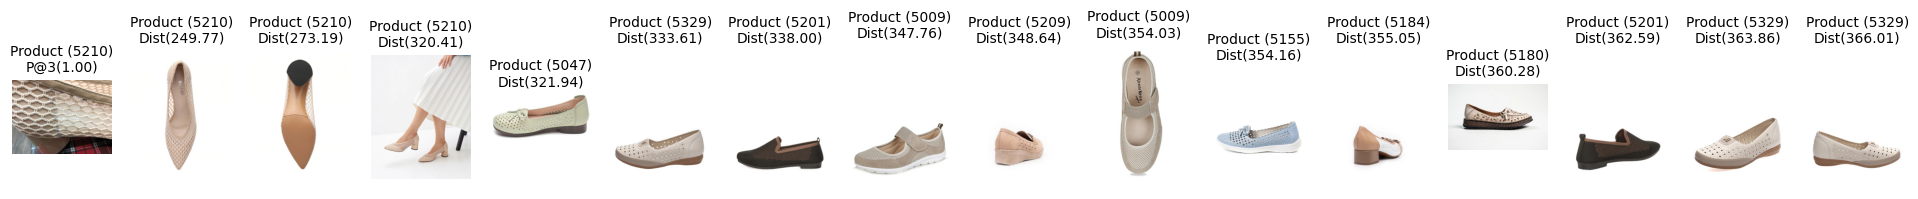

153 predictions [3556 3556 3556 3475 3539 3610 3476 3525 3686 3633 3478 3525 3640 3460
 3460] truth 3556


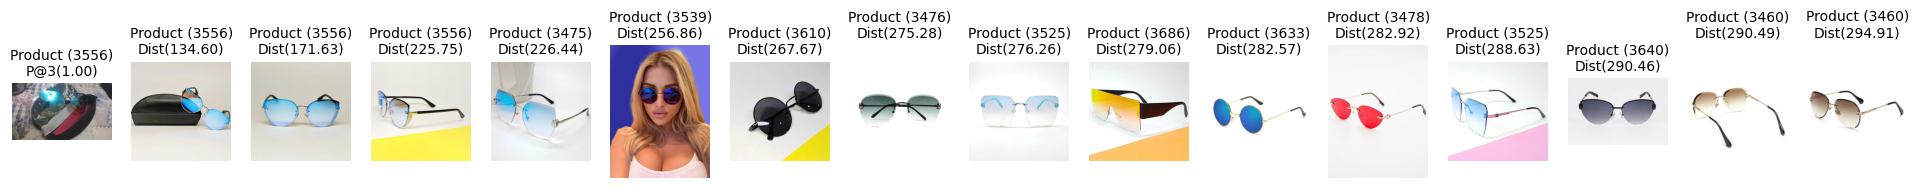

1277 predictions [5297 5297 5297 5335 5345 5335 5073 5073 5073 5008 5349 5098 5295 5008
 5078] truth 5297


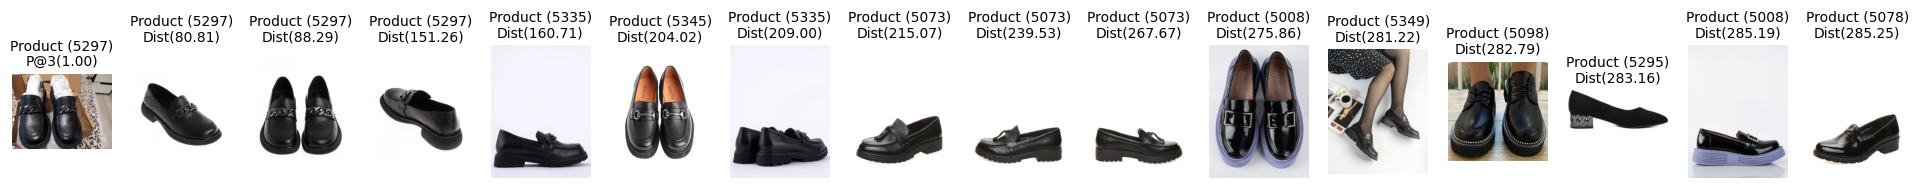

473 predictions [3696 3696 3696 3475 3525 3639 3594 3525 3647 3631 3460 3564 3476 3556
 3460] truth 3696


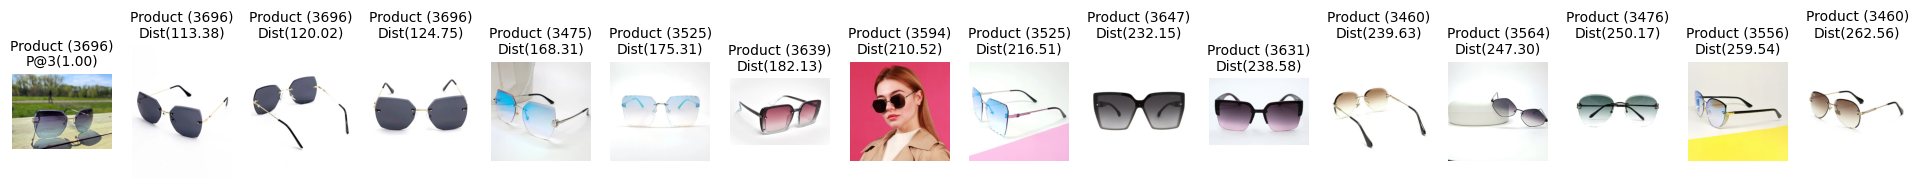

1533 predictions [5073 5073 5073 5073 5335 5297 5335 5108 5078 5223 5131 5345 5130 5297
 5081] truth 5073


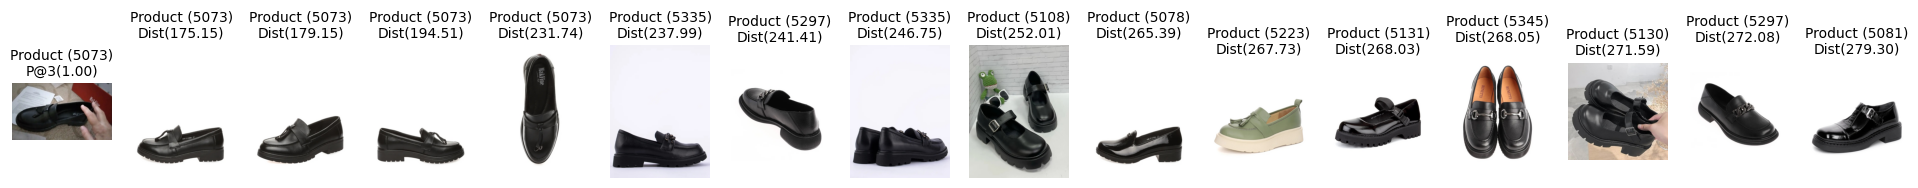

1646 predictions [5019 5019 5019 5038 5038 4970 5024 5024 5142 5066 5103 5350 5026 5350
 5103] truth 5019


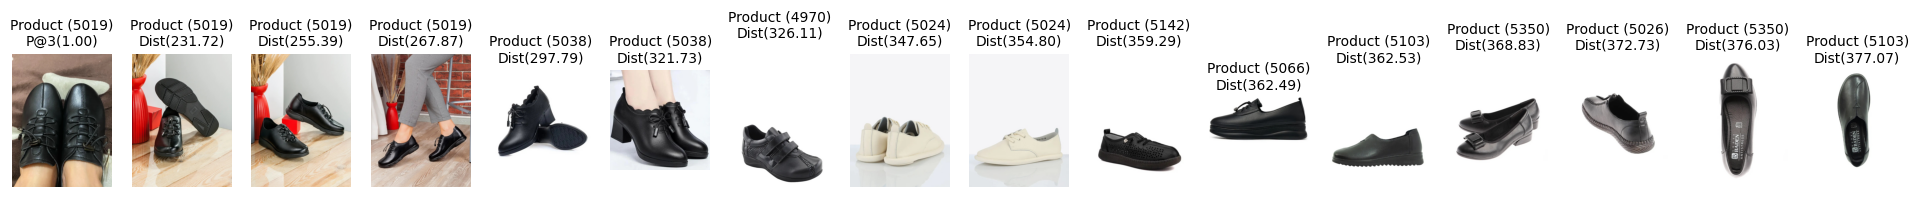

699 predictions [5043 5043 5043 5284 5232 5284 4993 5232 4960 5326 5132 4958 5014 5163
 5014] truth 5043


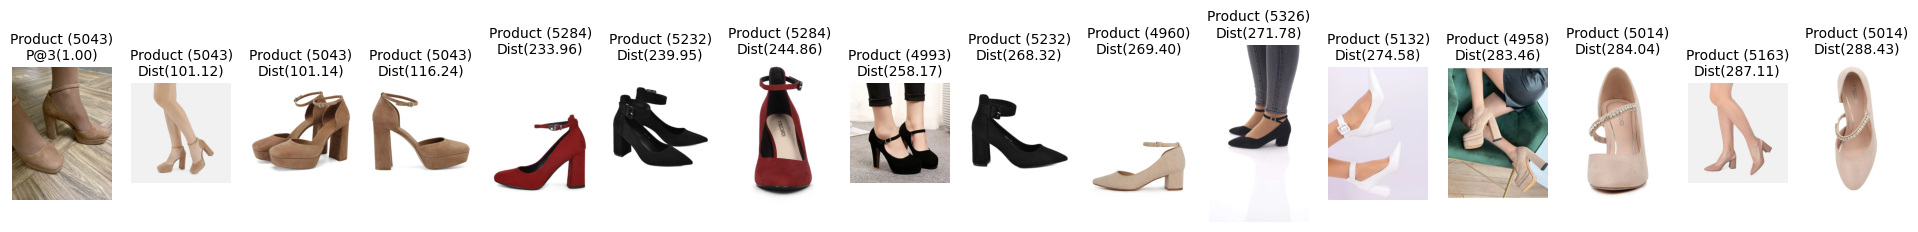

1327 predictions [3673 3673 3673 3537 3490 3702 3550 3514 3472 3511 3532 3702 3537 3532
 3651] truth 3673


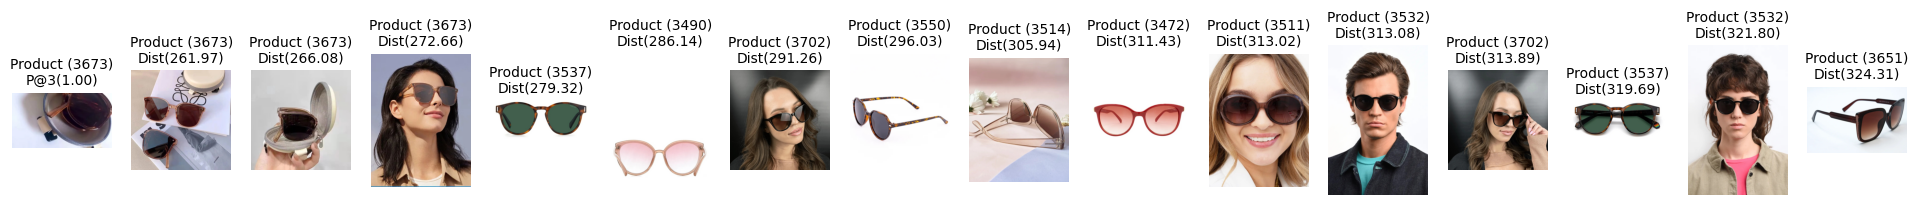

1545 predictions [5025 5025 5025 5026 5075 5286 5026 5075 5286 5152 5059 5152 5059 5059
 5007] truth 5025


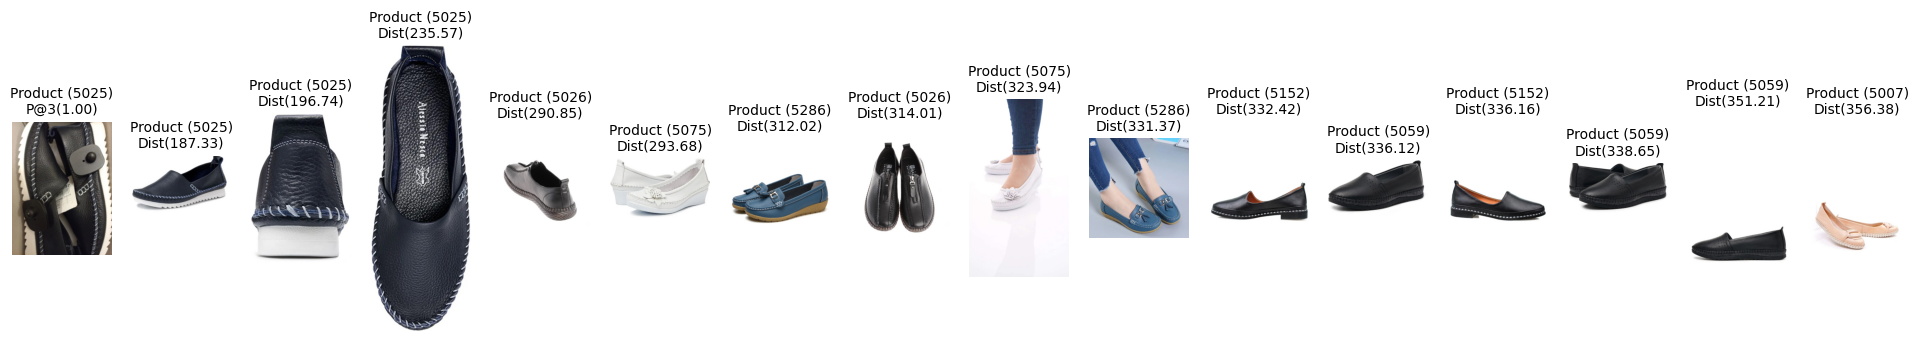

In [13]:
for i in worst_to_best[-100:-90]:
    idx_ = ind[i][:15]
    
    print(i, 'predictions', product_id_train[idx_], 'truth', product_id_test[i])
    img_path_q = img_path_test[i]
    img_path_g = [img_path_train[j] for j in idx_]
    plot_img(img_dir, 
             img_path_q, 
             img_path_g, 
             product_id_test[i], 
             product_id_train[idx_], 
             dist[i],
             map_score_per_image[i])

## Shopee

In [14]:
img_dir = "../shopee/train_images"

In [20]:
final_transform = get_final_transform()

dataset_shopee = ProductDataset(img_dir, 
                              '../shopee/train.csv', 
                              None, 
                              final_transform, 
                              headers = {"img_path": "image", "product_id": "label_group"})
dataloader_shopee = DataLoader(dataset_shopee, batch_size=512, num_workers=4)

features_shopee, img_path_shopee, product_id_shopee = extract_embeddings(model, dataloader_shopee, 1)



 58%|█████████████████████████████████████████████████████████████                                            | 39/67 [01:14<00:51,  1.83s/it]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1c1b5aff70>
Traceback (most recent call last):
  File "/home/cemmi/anaconda3/envs/aicrowd-product/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/home/cemmi/anaconda3/envs/aicrowd-product/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1430, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/home/cemmi/anaconda3/envs/aicrowd-product/lib/python3.8/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "/home/cemmi/anaconda3/envs/aicrowd-product/lib/python3.8/multiprocessing/popen_fork.py", line 44, in wait
    if not wait([self.sentinel], timeout):
  File "/home/cemmi/anaconda3/envs/aicrowd-product/lib/python3.8/mult

KeyboardInterrupt: 

In [ ]:
unique = np.unique(product_id_shopee)
for i in tqdm(range(len(product_id_shopee))):
    product_id_shopee[i] = np.where(unique == product_id_shopee[i])[0][0]

In [ ]:
dist_shopee, ind_shopee = utilities.get_similiarity_l2(features_shopee, features_shopee, 16)
worst_to_best_shopee, map_score_per_image_shopee = calculate_map_scores(
    product_id_shopee, 
    product_id_shopee, 
    ind_shopee
)

In [ ]:
for i in worst_to_best_shopee[10:20]:
    idx_ = ind_shopee[i][1:]
    
    print(i, 'predictions', product_id_shopee[idx_], 'truth', product_id_shopee[i])
    img_path_q = img_path_shopee[i]
    img_path_g = [img_path_shopee[j] for j in idx_]
    plot_img(img_dir, 
             img_path_q, 
             img_path_g, 
             product_id_shopee[i], 
             product_id_shopee[idx_], 
             dist_shopee[i][1:],
             map_score_per_image_shopee[i])

In [ ]:
for i in worst_to_best_shopee[-120:-110]:
    idx_ = ind_shopee[i][1:]
    
    print(i, 'predictions', product_id_shopee[idx_], 'truth', product_id_shopee[i])
    img_path_q = img_path_shopee[i]
    img_path_g = [img_path_shopee[j] for j in idx_]
    plot_img(img_dir, 
             img_path_q, 
             img_path_g, 
             product_id_shopee[i], 
             product_id_shopee[idx_], 
             dist_shopee[i][1:],
             map_score_per_image_shopee[i])

In [44]:
%%timeit -n 5

emb1 = np.random.random((9000, 512)).astype(np.float32)
emb2 = np.random.random((1100, 512)).astype(np.float32)
index = faiss.IndexFlatL2(512)
index.add(emb1)
_, ind = index.search(emb2, 1000)

313 ms ± 1.7 ms per loop (mean ± std. dev. of 7 runs, 5 loops each)


In [ ]:
310 ms ± 308 µs per loop (mean ± std. dev. of 7 runs, 5 loops each)
